# 0 - Introduction
In this notebook the problem will be formulated, and already existing solutions based on iterative algorithms will be shown.

On TCV, a tokamak located in Lausanne (Switzerland), a multi-spectral camera is installed that can measure different (line) emissions from the plasma. The figure below shows the rendered view from a CAD model of TCV. On the left we can see the rendered view, and on the right we can see the poloidal location of where the camera is located.
<p align="center">
<img src="files/mantis_camera_view.png" alt="mantis camera view" width="400"/>
</p>

The goal of this project is to find a fast way to reconstruct a poloidal emissivity from the measured camera image. An example of a measured camera image (left), and a reconstruction of the poloidal emissivity calculated using an iterative approach (right) are shown below. Mind that the camera view in this image is flipped left-to-right w.r.t. the render in the previous figure.
<p align="center">
<img src="files/example_data_pair.png" alt="example data pair" width="700"/>
</p>

## Model Description

The problem can be approximately modelled as a linear forward operator
$$y = Gx + e,$$
where $y$ is the camera image, $x$ the poloidal emissivity, $e$ the noise and $G$ the geometry matrix. Because $G$ is sparse, large, singular, and rectangular, pre-calculating a pseudo-inverse of this matrix is not a good idea. Instead, we can calculate an approximation of the poloidal emissivity iteratively by gradient descent:
$$ x_{k+1} = x_k + \mu G^T y - \mu G^T G x_k = \mu G^T y + (I - \mu G^T G ) x_k, $$
where $\mu$ is the step size. Another approach is to use the SIRT algorithm, which is stable for any $0 < \mu < 2$:
$$ x_{k+1} = \mu C G^T R y + (I - \mu CG^T RG) x_k, $$
where $C$ is a diagonal matrix containing the inverse column sums, and $R$ a diagonal matrix containing the inverse row sums.

In [1]:
# imports needed for iterative example
%load_ext autoreload
%autoreload 2

import time

import definitions
import matplotlib.pyplot as plt
from src.data.utils import load_geometry_matrix
from src.data.grid import create_grid_transformation_matrices
import numpy as np
from PIL import Image
from scipy.sparse import diags
from src.visualisation.visualise import plot_poloidal_cs

In [2]:
geometry_id = "65903_cam_10"
rect_to_tri, _ = create_grid_transformation_matrices(geometry_id, (256, 256))
G = load_geometry_matrix(geometry_id)

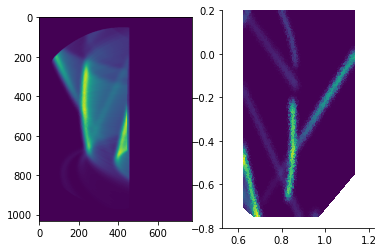

In [3]:
example_inversion = Image.open("files/example_inversion_synth.png")
# we reshape to a vector, because we are using basic 2D matrix multiplications, instead of tensor operators

scaling_factor = (
    3.936 / 1.364
)  # scaling factor comes from data generation, i.e. to fully utilize the 8 bits to store information of the camera image and the inversion
x = (
    rect_to_tri
    @ np.array(example_inversion).reshape(-1)
    / 255
    * scaling_factor
)
y = G @ x
example_image = (y).reshape((1032, 772))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(example_image)
plot_poloidal_cs(x, axs[1])

In [4]:
def gradient_descent(G, y, x0, mu: float, n_iterations: int):
    x_k = x0

    # precompute values
    muGTy = mu * G.transpose() @ y
    muGTG = mu * G.transpose() @ G

    start = time.time()
    for i in range(n_iterations):
        x_k = muGTy + x_k - muGTG @ x_k
    end = time.time()
    print(
        f"Gradient descent took {end - start:.1f} seconds; {(end - start) / n_iterations:.3f} s per iteration"
    )
    return x_k


def sirt(G, y, x0, mu: float, n_iterations: int):
    x_k = x0

    # ignore and convert nan to num, because sum(G, axis=1) can contain zeros
    with np.errstate(divide="ignore"):
        R = diags(1 / np.squeeze(np.sum(G, axis=1).A))
        C = diags(1 / np.squeeze(np.sum(G, axis=0).A))

    muCGTRy = mu * np.nan_to_num(C @ G.transpose() @ R @ y)
    muCGTRG = mu * np.nan_to_num(C @ G.transpose() @ R @ G).todense().A

    start = time.time()
    for i in range(n_iterations):
        x_k = muCGTRy + x_k - muCGTRG @ x_k
    end = time.time()
    print(
        f"SIRT took {end - start:.1f} seconds; {(end - start) / n_iterations:.3f} s per iteration"
    )
    return x_k

In [5]:
x0 = np.zeros(14549)
x_hat_gd = gradient_descent(G, y, x0, 0.02, 100)
x_hat_sirt = sirt(G, y, x0, 2, 100)

Gradient descent took 8.1 seconds; 0.081 s per iteration
SIRT took 25.7 seconds; 0.257 s per iteration


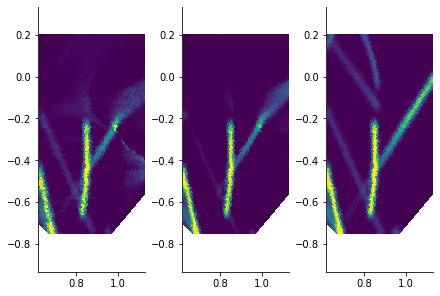

In [6]:
fig, axs = plt.subplots(1, 3, constrained_layout=True)
plot_poloidal_cs(x_hat_gd, axs[0], vmin=0, vmax=2)
plot_poloidal_cs(x_hat_sirt, axs[1], vmin=0, vmax=2)
plot_poloidal_cs(x, axs[2], vmin=0, vmax=2)